## Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи.  
Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор.  
Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. 

Задача — обучить на этих данных модель для прогноза оттока клиентов.



## Библиотеки, константы, параметры

In [2]:
# imports
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.samplers import TPESampler
import pandas as pd
import phik
from phik.report import plot_correlation_matrix
import re
import seaborn as sns
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sqlalchemy import create_engine
import torch
import torch.nn as nn

# constants
RS = 150124 # Random Seed

# parameters
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_columns', 30)
pd.set_option('mode.chained_assignment', None)
pd.options.display.max_colwidth = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(RS)
torch.manual_seed(RS)
torch.cuda.manual_seed(RS)
torch.backends.cudnn.deterministic = False	
torch.use_deterministic_algorithms(False)

In [3]:
# DB configuration
db_config = {
    'user': 'praktikum_student',
    'pwd': 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'db': 'data-science-final'
}

connection_string = f"postgresql://{db_config['user']}:{db_config['pwd']}@{db_config['host']}:{db_config['port']}/{db_config['db']}"

# Connection
engine = create_engine(connection_string) 

In [4]:
# Test connection

query = '''
SELECT *
FROM telecom.contract
LIMIT 10;
'''

contract = pd.read_sql_query(query, con=engine) 

contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15


## Загрузка и знакомство с данными

In [5]:
contract = '''
SELECT *
FROM telecom.contract
'''

contract = pd.read_sql_query(contract, con=engine) 

personal = '''
SELECT *
FROM telecom.personal
'''

personal = pd.read_sql_query(personal, con=engine) 

internet = '''
SELECT *
FROM telecom.internet
'''

internet = pd.read_sql_query(internet, con=engine)
internet.columns = internet.iloc[0]
internet.drop(index=0, axis=0, inplace=True)

phone = '''
SELECT *
FROM telecom.phone
'''

phone = pd.read_sql_query(phone, con=engine) 
phone.columns = phone.iloc[0]
phone.drop(index=0, axis=0, inplace=True)

In [6]:
# функция для ознакомления с данными

def first_look(data):
    display(data.info())
    print('='*30)
    display(data.describe())
    print('='*30)
    print('Дубликатов обнаружено: ', data.duplicated().sum())
    print('='*30)
    try:
        data.hist(figsize=(12, 10), bins=25)
        plt.show()
    except:
        print('Нет данных для построения гистограмм!')
    print('='*30)
    print('Размер датасета:', data.shape)
    print('='*30)
    print('Пропуски')
    print(data.isna().sum())
    display(data.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


None

,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


Дубликатов обнаружено:  0


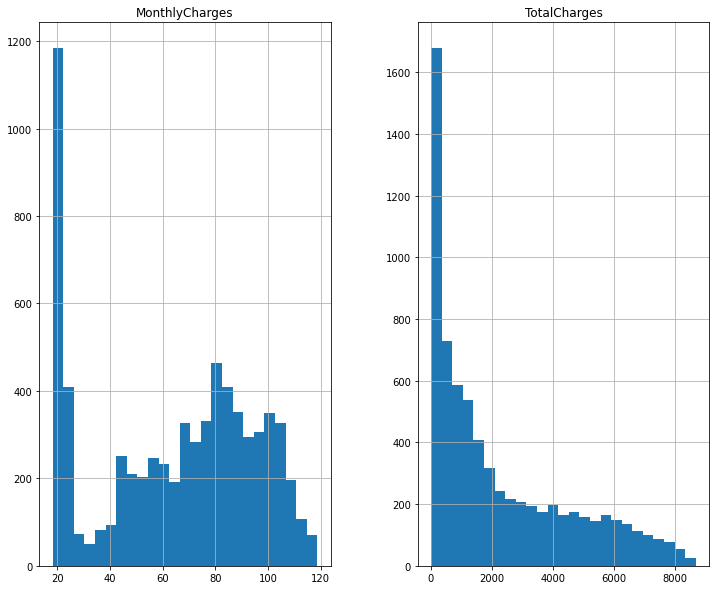

Размер датасета: (7043, 8)
Пропуски
customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
dtype: int64


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3507,8076-FEZKJ,2019-06-16,None,One year,No,Mailed check,19.50,225.85
2135,9498-FIMXL,2018-12-10,None,One year,Yes,Mailed check,19.20,161.95
1346,1602-IJQQE,2019-05-12,2020-01-01,Month-to-month,No,Electronic check,75.35,338.10
4858,0440-QEXBZ,2018-10-02,None,Month-to-month,Yes,Mailed check,50.15,2139.10
1605,4250-ZBWLV,2019-02-16,2019-10-01,One year,No,Electronic check,108.45,7176.55
4770,8851-RAGOV,2019-02-03,None,Month-to-month,Yes,Mailed check,71.05,1837.70
25,1658-BYGOY,2018-11-25,2020-01-01,Month-to-month,Yes,Electronic check,95.45,1752.55
1347,4628-WQCQQ,2019-05-25,2019-12-01,One year,Yes,Electronic check,85.15,3030.60
1425,9689-PTNPG,2018-10-11,2019-10-01,Month-to-month,Yes,Electronic check,80.25,144.55
6106,5937-EORGB,2018-09-22,None,Month-to-month,Yes,Electronic check,96.50,1392.25


In [7]:
first_look(contract)

#### Кратко о данных `contract`

В таблице 7043 записи, практически все колонки без пропусков.  
Исключение - `EndDate` - более 5000 пропусков. Это абоненты, не разоорвавшие контракт.  
Небольшое количество пропусков содержит и столбец `TotalCharges`

Ежемесячно абоненты тратят от 18,25 до 118,75, общие затраты - от 18,80 до 8684.80.  
В среднем ежемесячные затраты составляют 64.76, общие - 2283.30.

Добовольно большое число абонентов предпочитает не раскошеливаться и платить по минимуму, что видно из гистограмм.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Дубликатов обнаружено:  0


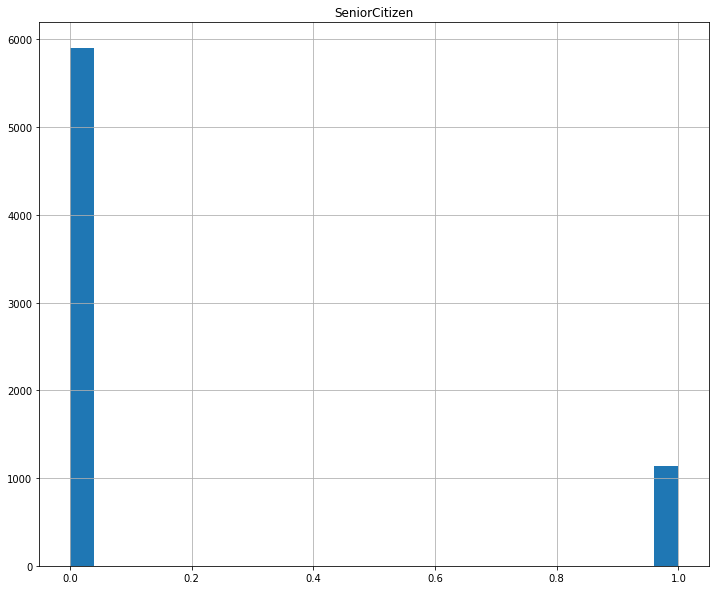

Размер датасета: (7043, 5)
Пропуски
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


,customerID,gender,SeniorCitizen,Partner,Dependents
5549,0329-GTIAJ,Female,0,No,No
2008,9430-FRQOC,Female,0,No,Yes
2222,8378-LKJAF,Male,0,Yes,Yes
489,8372-JUXUI,Male,0,No,Yes
1089,4546-FOKWR,Female,0,No,No
5945,8421-WZOOW,Female,1,Yes,Yes
1729,8226-BXGES,Male,0,Yes,No
4468,7083-YNSKY,Female,0,No,No
4634,9426-SXNHE,Female,0,No,No
999,3234-VKACU,Male,0,No,No


In [8]:
first_look(personal)

#### Кратко о данных `personal`

Здесь также 7043 записи, пропусков и дубликатов нет.  

Пенсионеров-клиентов чуть более тысячи человек.

In [9]:
first_look(internet)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 387.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,6281-FKEWS,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Дубликатов обнаружено:  0
Нет данных для построения гистограмм!
Размер датасета: (5517, 8)
Пропуски
0
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4753,4024-CSNBY,Fiber optic,Yes,Yes,Yes,Yes,No,No
973,7979-CORPM,Fiber optic,No,Yes,No,No,Yes,No
842,5981-ITEMU,Fiber optic,No,No,No,No,Yes,Yes
4443,2522-WLNSF,DSL,No,No,Yes,Yes,Yes,No
753,5709-LVOEQ,DSL,Yes,Yes,Yes,No,Yes,Yes
4152,1941-HOSAM,Fiber optic,No,No,No,No,Yes,Yes
1663,7422-WNBTY,Fiber optic,No,Yes,Yes,No,No,Yes
1929,9050-IKDZA,Fiber optic,No,No,No,No,Yes,No
1961,7641-EUYET,Fiber optic,Yes,Yes,Yes,No,Yes,No
4143,5647-FXOTP,Fiber optic,No,Yes,Yes,No,Yes,Yes


#### Кратко о данных `internet`

Записей в таблице 5518, пропусков и дубликатов нет.  
Видимо, это только те абоненты, которые используют услуги интернета.

Большинство баонентов предпочитают оптоволоконный канал и не покупают дополнительне услуги.

Из услуг наиболее популярны ТВ и кино.


In [10]:
first_look(phone)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6361 entries, 1 to 6361
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 149.1+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,3213-VVOLG,No
freq,1,3390


Дубликатов обнаружено:  0
Нет данных для построения гистограмм!
Размер датасета: (6361, 2)
Пропуски
0
customerID       0
MultipleLines    0
dtype: int64


,customerID,MultipleLines
5996,1074-WVEVG,No
120,7799-LGRDP,Yes
4547,0052-DCKON,Yes
5711,0186-CAERR,Yes
4536,4816-JBHOV,No
5066,2657-ALMWY,No
3278,3038-PQIUY,Yes
1610,6519-CFDBX,No
5412,9782-LGXMC,No
5048,3057-VJJQE,Yes


#### Кратко о данных `phone`

В таблице 6362 записи - это пользователи телефонной связи.  
Пропусков нет.

Большинство абонентов использую одну линию.

### Краткий вывод

Данные загружены и бегло просмотрены.  

Работать с данными можно, критических моментов не выявлено.  
Итоговый датасет будет содержать 7043 строки.


#### Функции


In [11]:
def rename_columns(data):
    """
    Return snake-cased columns name from camel-cased columns name in lowercase
    """
    data.columns = [re.sub(r'([a-z])([A-Z])', r'\g<1>_\g<2>', x).lower() for x in data.columns]
    
    return data

## Исследовательский анализ и предобработка данных

### Таблица `contract`

In [12]:
contract = rename_columns(contract)

In [13]:
contract

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,Two year,Yes,Bank transfer (automatic),21.15,1419.40
7039,6840-RESVB,2019-02-26,None,One year,Yes,Mailed check,84.80,1990.50
7040,2234-XADUH,2019-09-02,None,One year,Yes,Credit card (automatic),103.20,7362.90
7041,4801-JZAZL,2019-06-26,None,Month-to-month,Yes,Electronic check,29.60,346.45


In [14]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           1869 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Поскольку данные представлены не до сегодняшней даты, действующим контрактом будем считать  
на максимальную дату начала контракта

In [15]:
# Заполним пропуски

contract['end_date'].fillna(contract['begin_date'].max(), inplace=True)

# Приведем даты к типу Date

contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d').dt.round('1d')
contract['end_date'] = pd.to_datetime(contract['end_date'], format='%Y-%m-%d').dt.round('1d')



In [16]:
print('Begin max date:', contract['begin_date'].max())
print('End max date:', contract['end_date'].max())

Begin max date: 2020-02-01 00:00:00
End max date: 2020-02-01 00:00:00


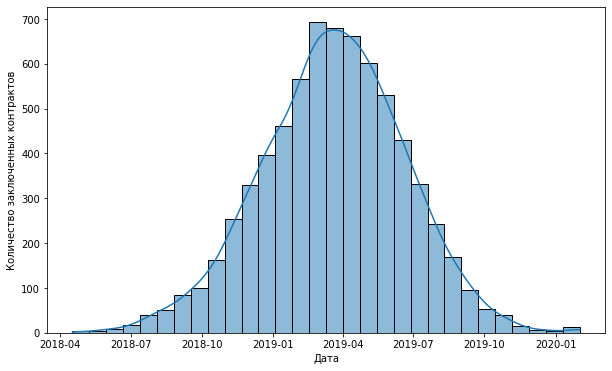

In [17]:
sns.histplot(data=contract, x='begin_date', bins=30, kde=True)

plt.xlabel('Дата')
plt.ylabel('Количество заключенных контрактов')

plt.show()


Из гистограммы видно, что данные представлены за период с апреля 2018 г. по январь 2020 г.  
Основной пик прироста абонентской базы был с февраля по июнь 2019 г.

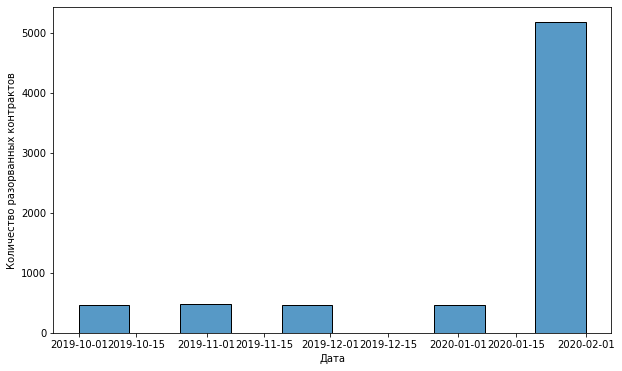

In [18]:
sns.histplot(
    data=contract, 
    x='end_date', 
    bins=10
)

plt.xlabel('Дата')
plt.ylabel('Количество разорванных контрактов')

plt.show()


Разрывать контракты абоненты стали в октябре 2019 г.  
Каждый месяц оператор теряет около 450 абонентов.

In [19]:
# Столбец type
contract['type'].unique()


array(['Two year', 'Month-to-month', 'One year'], dtype=object)

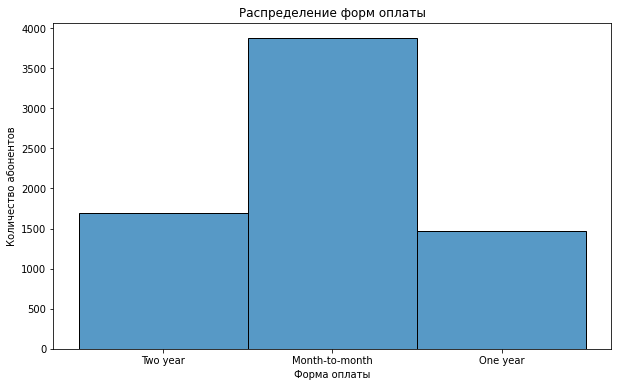

In [20]:
sns.histplot(data=contract, x='type')

plt.xlabel('Форма оплаты')
plt.ylabel('Количество абонентов')
plt.title('Распределение форм оплаты')

plt.show()


Половина абонентов предпочли помесячный план оплаты, примерно по четверти — годовую и двухгодовую формы оплаты.

In [21]:
contract['paperless_billing'].unique()

array(['Yes', 'No'], dtype=object)

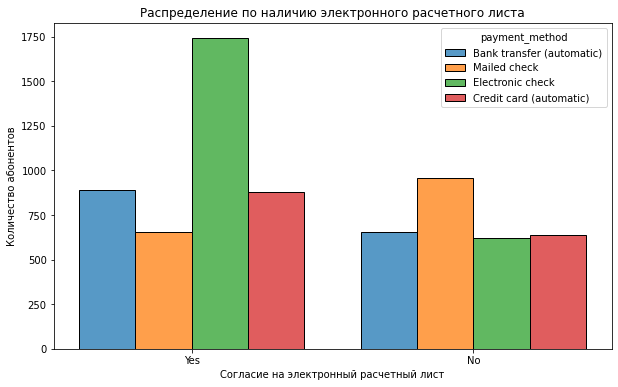

In [22]:
sns.histplot(data=contract, shrink=.8, x='paperless_billing', hue='payment_method', multiple="dodge")

plt.xlabel('Согласие на электронный расчетный лист')
plt.ylabel('Количество абонентов')
plt.title('Распределение по наличию электронного расчетного листа')

plt.show()


Более половины абонентов предпочли отказаться от наличной оплаты.  
В каждой категории очевидный лидер - "электронщики" предпочитают электронный расчетный лист, "бумажники" - почтовый.

Тем не менее автоматическую оплату выбрали примерно половина абонентов с электронным листом и более половины предочитающих физическую версию.  


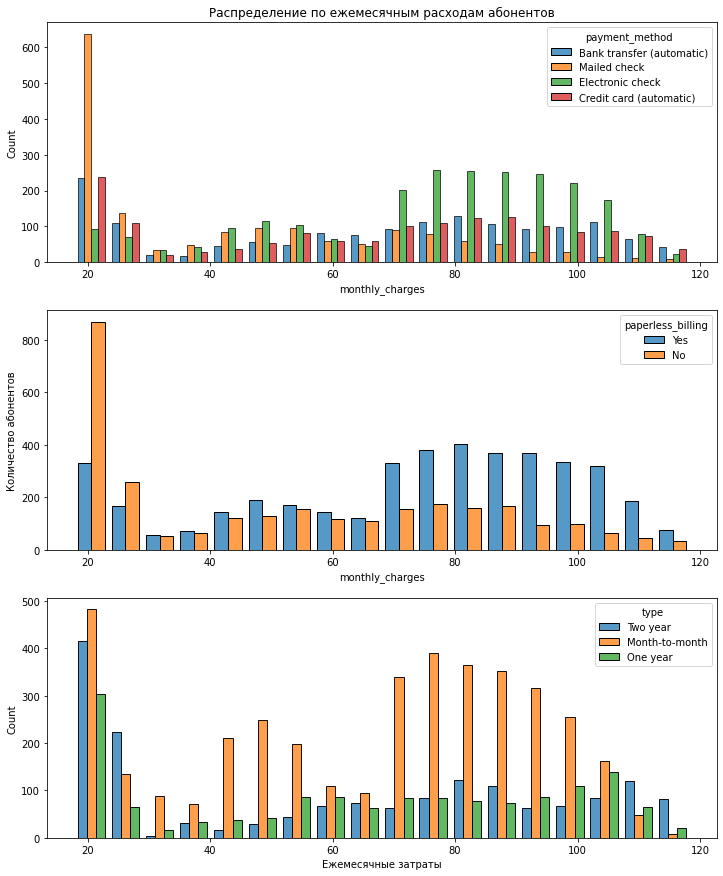

In [23]:
plt.figure(figsize=(12, 15))

plt.subplot(3, 1, 1)
sns.histplot(data=contract, shrink=.8, x='monthly_charges', hue='payment_method', multiple="dodge")
plt.title('Распределение по ежемесячным расходам абонентов')

plt.subplot(3, 1, 2)
sns.histplot(data=contract, shrink=.8, x='monthly_charges', hue='paperless_billing', multiple="dodge")
plt.ylabel('Количество абонентов')


plt.subplot(3, 1, 3)
sns.histplot(data=contract, shrink=.8, x='monthly_charges', hue='type', multiple="dodge")

plt.xlabel('Ежемесячные затраты')

plt.show()


Заметна лидирующая категория "консерваторов" - бумажный чек и минимальная оплата.

С другой стороны видны активные "digital"-пользователи - с более высокими затратами, отсутствием бумажных чеков и автоматической оплатой счетов. 

Также заметна тенденция к помесячной оплате. "Долгие" планы популярнее с низкими затратами. 

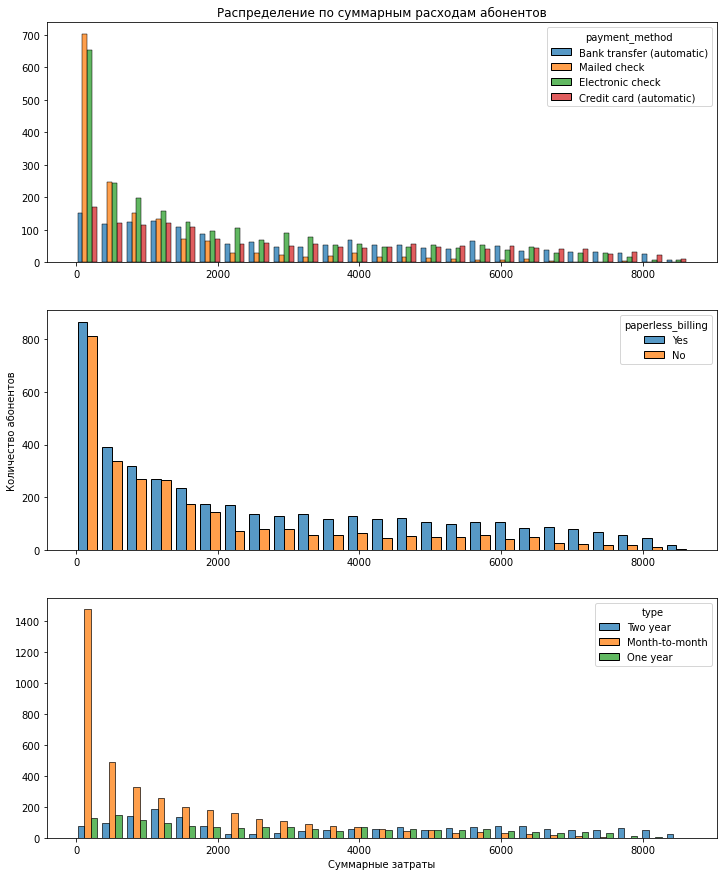

In [24]:
plt.figure(figsize=(12, 15))

plt.subplot(3, 1, 1)
sns.histplot(data=contract, shrink=.8, x='total_charges', hue='payment_method', multiple="dodge")
plt.title('Распределение по суммарным расходам абонентов')
plt.xlabel('')
plt.ylabel('')


plt.subplot(3, 1, 2)
sns.histplot(data=contract, shrink=.8, x='total_charges', hue='paperless_billing', multiple="dodge")
plt.xlabel('')
plt.ylabel('Количество абонентов')


plt.subplot(3, 1, 3)
sns.histplot(data=contract, shrink=.8, x='total_charges', hue='type', multiple="dodge")

plt.xlabel('Суммарные затраты')
plt.ylabel('')


plt.show()


Еще раз убеждаемся, что большинство абонентов предпочитают платить ежемесячно и по минимуму.

### Таблица `personal`

In [25]:
personal = rename_columns(personal)

In [26]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [27]:
personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


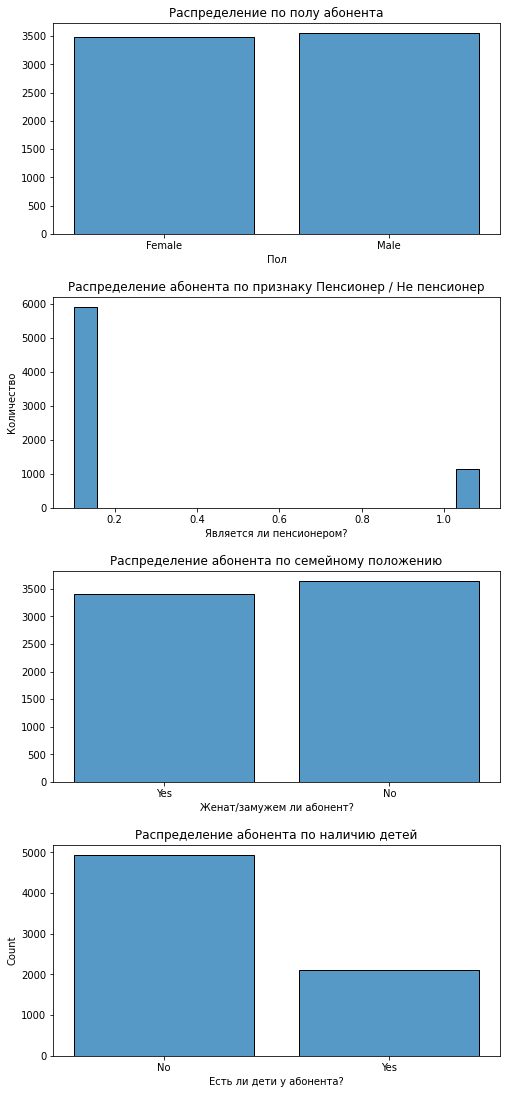

In [28]:
plt.figure(figsize=(8, 19))
plt.subplots_adjust(hspace = 0.3)

plt.subplot(4, 1, 1)
sns.histplot(data=personal, shrink=.8, x='gender')
plt.title('Распределение по полу абонента')
plt.xlabel('Пол')
plt.ylabel('')


plt.subplot(4, 1, 2)
sns.histplot(data=personal, shrink=.8, x='senior_citizen')
plt.title('Распределение абонента по признаку Пенсионер / Не пенсионер')
plt.xlabel('Является ли пенсионером?')
plt.ylabel('Количество')


plt.subplot(4, 1, 3)
sns.histplot(data=personal, shrink=.8, x='partner')
plt.title('Распределение абонента по семейному положению')

plt.xlabel('Женат/замужем ли абонент?')
plt.ylabel('')


plt.subplot(4, 1, 4)
sns.histplot(data=personal, shrink=.8, x='dependents')
plt.title('Распределение абонента по наличию детей')

plt.xlabel('Суммарные затраты')
plt.xlabel('Есть ли дети у абонента?')


plt.show()


Итак, по полу распределение абонентов практически равное, немного больше мужчин.  
Пенсионеров — около 1/7.  
Также немного больше неженатых абонентов, и примерно 2/3 не имеют детей.

### Таблица `internet`

In [29]:
internet = rename_columns(internet)

In [30]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 387.9+ KB


In [31]:
internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No


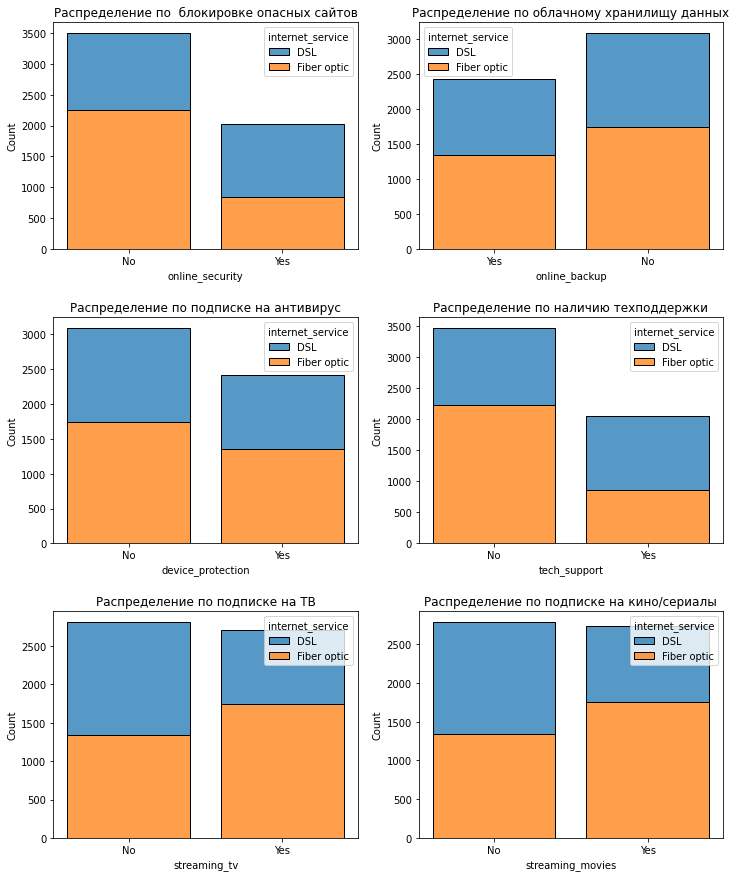

In [32]:
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

plt.subplots_adjust(hspace = 0.3)

sns.histplot(ax=axes[0, 0], data=internet, shrink=.8, x='online_security', hue='internet_service', multiple='stack')
axes[0, 0].set_title('Распределение по  блокировке опасных сайтов')


sns.histplot(ax=axes[0, 1], data=internet, shrink=.8, x='online_backup', hue='internet_service', multiple='stack')
axes[0, 1].set_title('Распределение по облачному хранилищу данных')


sns.histplot(ax=axes[1, 0], data=internet, shrink=.8, x='device_protection', hue='internet_service', multiple='stack')
axes[1, 0].set_title('Распределение по подписке на антивирус')


sns.histplot(ax=axes[1, 1], data=internet, shrink=.8, x='tech_support', hue='internet_service', multiple='stack')
axes[1, 1].set_title('Распределение по наличию техподдержки')


sns.histplot(ax=axes[2, 0], data=internet, shrink=.8, x='streaming_tv', hue='internet_service', multiple='stack')
axes[2, 0].set_title('Распределение по подписке на ТВ')


sns.histplot(ax=axes[2, 1], data=internet, shrink=.8, x='streaming_movies', hue='internet_service', multiple='stack')
axes[2, 1].set_title('Распределение по подписке на кино/сериалы')



plt.show()


В целом допуслуги чаще не покупают.  
Из покупаемых популярны ТВ- и кино-сервисы, техподдержка - наименее востребованный сервис.

Также видно, что сервисы, требующие высокой скорости доступа в  (облако, ТВ, кино), популярнее у пользователей оптоволоконной линии.

### Таблица `phone`

In [33]:
phone = rename_columns(phone)

In [34]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6361 entries, 1 to 6361
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 149.1+ KB


In [35]:
phone.head()

,customer_id,multiple_lines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes


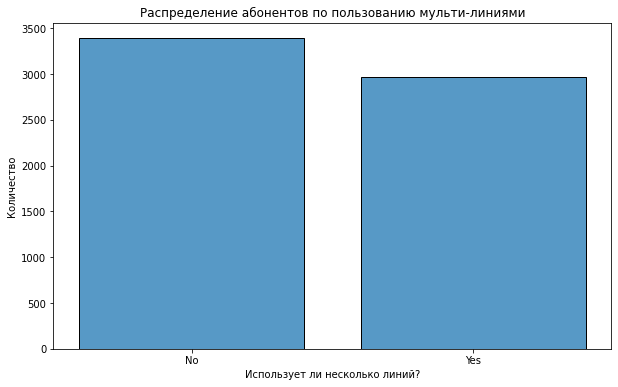

In [36]:
sns.histplot(data=phone, shrink=.8, x='multiple_lines')
plt.title('Распределение абонентов по пользованию мульти-линиями')

plt.xlabel('Использует ли несколько линий?')
plt.ylabel('Количество')

plt.show()

Примерно 3000 абонентов используют несколько линий, около 3300 - нет.

В общем телефон чуть более популярен, чем интернет

### Краткий вывод

Более подробно исследованы отдельные таблицы. Из них узнали, что:
* период наблюдения — с апреля 2018 г. по январь 2020 г.;
* наиболее популярен помесячный план оплаты;
* по полу и по семейному положению абоненты распределены примерно поровну, пенсионеров около 1/7 от общего числа;
* у пользователей интеренета наиболее популяны допуслуги стриминговых сервисов.

## Объединение данных

Соберем данные в общую таблицу для подготовки признаков для обучения моделей машинного обучения.  

Заполним пропуски, посмотрим на выбросы и аномальные значения.  


In [37]:
data = pd.merge(contract, phone, how='outer', on='customer_id').merge(internet, how='outer', on='customer_id').merge(personal, on='customer_id', how='outer')

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   multiple_lines     6361 non-null   object        
 9   internet_service   5517 non-null   object        
 10  online_security    5517 non-null   object        
 11  online_backup      5517 non-null   object        
 12  device_protection  5517 non-null   object        
 13  tech_support       5517 non-null   object        
 14  streamin

In [39]:
data.describe()

,monthly_charges,total_charges,senior_citizen
count,7043.000000,7032.000000,7043.000000
mean,64.761692,2283.300441,0.162147
std,30.090047,2266.771362,0.368612
min,18.250000,18.800000,0.000000
25%,35.500000,401.450000,0.000000
50%,70.350000,1397.475000,0.000000
75%,89.850000,3794.737500,0.000000
max,118.750000,8684.800000,1.000000


In [40]:
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,NaN,DSL,Yes,No,Yes,Yes,Yes,No,Female,0,Yes,Yes
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,No,Yes
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,No,DSL,Yes,Yes,No,No,No,No,Male,0,No,No
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,No,Fiber optic,No,No,No,No,No,No,Female,0,No,No


In [41]:
data.replace({'Yes': 1, 'No': 0}, inplace=True)

In [42]:
data.describe()

,paperless_billing,monthly_charges,total_charges,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,senior_citizen,partner,dependents
count,7043.000000,7043.000000,7032.000000,6361.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,7043.000000,7043.000000,7043.000000
mean,0.592219,64.761692,2283.300441,0.467065,0.365960,0.440276,0.439007,0.370491,0.490665,0.495197,0.162147,0.483033,0.299588
std,0.491457,30.090047,2266.771362,0.498953,0.481742,0.496465,0.496311,0.482980,0.499958,0.500022,0.368612,0.499748,0.458110
min,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,35.500000,401.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,70.350000,1397.475000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,89.850000,3794.737500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
data.query('total_charges.isna()')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,NaN,NaN,DSL,1.0,0.0,1.0,1.0,1.0,0.0,Female,0,1,1
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,0,1
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,0,Mailed check,80.85,NaN,0.0,DSL,1.0,1.0,1.0,0.0,1.0,1.0,Female,0,1,1
6,4367-NUYAO,2020-02-01,2020-02-01,Two year,0,Mailed check,25.75,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,1,1
7,1371-DWPAZ,2020-02-01,2020-02-01,Two year,0,Credit card (automatic),56.05,NaN,NaN,DSL,1.0,1.0,1.0,1.0,1.0,0.0,Female,0,1,1
9,3213-VVOLG,2020-02-01,2020-02-01,Two year,0,Mailed check,25.35,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,1,1
10,2923-ARZLG,2020-02-01,2020-02-01,One year,1,Mailed check,19.70,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,1,1
11,2775-SEFEE,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),61.90,NaN,1.0,DSL,1.0,1.0,0.0,1.0,0.0,0.0,Male,0,0,1
4408,7644-OMVMY,2020-02-01,2020-02-01,Two year,0,Mailed check,19.85,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,1,1
5160,2520-SGTTA,2020-02-01,2020-02-01,Two year,0,Mailed check,20.00,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,1,1


Вероятно, это заключенные, но еще не оплаченные договоры. 
Заполним нулями, так как фактически расходов еще не было

In [44]:
data['total_charges'].fillna(0, inplace=True)

Колонки с дополнительными услугами также заполним пропуски нулями.  
Исходим из того, что пропуск появляется либо у пользователей, пользующихся только одним видом услуг (либо телфон, либо интернет),  
либо просто не заполнено в исходной БД. И первое, и второе наиболее вероятно говорит о том, что услугу абонент не покупал.

In [45]:
data[['multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']] = data[['multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']].fillna(0).astype('int')

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   multiple_lines     7043 non-null   int64         
 9   internet_service   5517 non-null   object        
 10  online_security    7043 non-null   int64         
 11  online_backup      7043 non-null   int64         
 12  device_protection  7043 non-null   int64         
 13  tech_support       7043 non-null   int64         
 14  streamin

В колонке `internet_service` заполним пропуски как `None` - если абонент не покупал подключение к интернету, то типа подключения не будет

In [47]:
data['internet_service'].fillna('None', inplace=True)

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   multiple_lines     7043 non-null   int64         
 9   internet_service   7043 non-null   object        
 10  online_security    7043 non-null   int64         
 11  online_backup      7043 non-null   int64         
 12  device_protection  7043 non-null   int64         
 13  tech_support       7043 non-null   int64         
 14  streamin

#### Категориальные признаки

Категориальные признаки - это столбцы `type`, `payment_method`, `internet_service`.  
Столбец `gender` переименуем в `is_male` и заменим строковые данные на 1, если мужчина, и на 0, если женщина

In [49]:
data[['type', 'payment_method', 'internet_service']] = data[['type', 'payment_method', 'internet_service']].astype('category')

data = data.rename(columns={'gender': 'is_male'})

data.loc[data['is_male'].str.lower() == 'male', 'is_male'] = 1
data.loc[data['is_male'].str.lower() == 'female', 'is_male'] = 0

data['is_male'] = data['is_male'].astype('int')

In [50]:
data.sample(10)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,is_male,senior_citizen,partner,dependents
2929,7560-QRBXH,2019-03-09,2020-02-01,One year,0,Mailed check,19.95,936.70,0,None,0,0,0,0,0,0,0,0,0,1
4602,7032-LMBHI,2019-03-17,2020-02-01,One year,0,Bank transfer (automatic),64.65,2347.85,1,DSL,1,0,0,0,1,0,0,0,0,0
2456,0139-IVFJG,2019-08-09,2020-02-01,Month-to-month,0,Electronic check,90.35,190.50,0,Fiber optic,1,1,0,0,1,0,0,0,1,0
3453,6648-INWPS,2019-08-19,2020-02-01,Month-to-month,0,Electronic check,20.15,341.35,0,None,0,0,0,0,0,0,1,0,1,1
125,9399-APLBT,2019-01-02,2019-12-01,Month-to-month,1,Electronic check,74.70,74.70,0,Fiber optic,0,1,0,0,0,0,0,0,1,1
3804,5945-AZYHT,2019-02-09,2020-02-01,One year,1,Electronic check,109.60,7854.15,1,Fiber optic,1,1,1,0,1,1,1,0,1,0
881,8276-MQBYC,2018-12-26,2019-11-01,Month-to-month,1,Electronic check,97.80,4913.30,1,Fiber optic,0,0,1,0,1,1,1,1,0,0
1930,0434-CSFON,2019-08-19,2020-02-01,Month-to-month,1,Electronic check,100.50,4707.10,1,Fiber optic,0,0,1,0,1,1,0,0,1,0
5051,0559-CKHUS,2019-01-31,2020-02-01,Two year,1,Mailed check,19.55,521.80,0,None,0,0,0,0,0,0,0,0,1,0
4244,6772-WFQRD,2019-08-31,2020-02-01,One year,1,Bank transfer (automatic),20.40,854.90,0,None,0,0,0,0,0,0,1,0,0,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   category      
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   multiple_lines     7043 non-null   int64         
 9   internet_service   7043 non-null   category      
 10  online_security    7043 non-null   int64         
 11  online_backup      7043 non-null   int64         
 12  device_protection  7043 non-null   int64         
 13  tech_support       7043 non-null   int64         
 14  streamin

None

,paperless_billing,monthly_charges,total_charges,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,is_male,senior_citizen,partner,dependents
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.592219,64.761692,2279.734304,0.421837,0.286668,0.344881,0.343888,0.290217,0.384353,0.387903,0.504756,0.162147,0.483033,0.299588
std,0.491457,30.090047,2266.794470,0.493888,0.452237,0.475363,0.475038,0.453895,0.486477,0.487307,0.500013,0.368612,0.499748,0.458110
min,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,35.500000,398.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,70.350000,1394.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,89.850000,3786.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Дубликатов обнаружено:  0


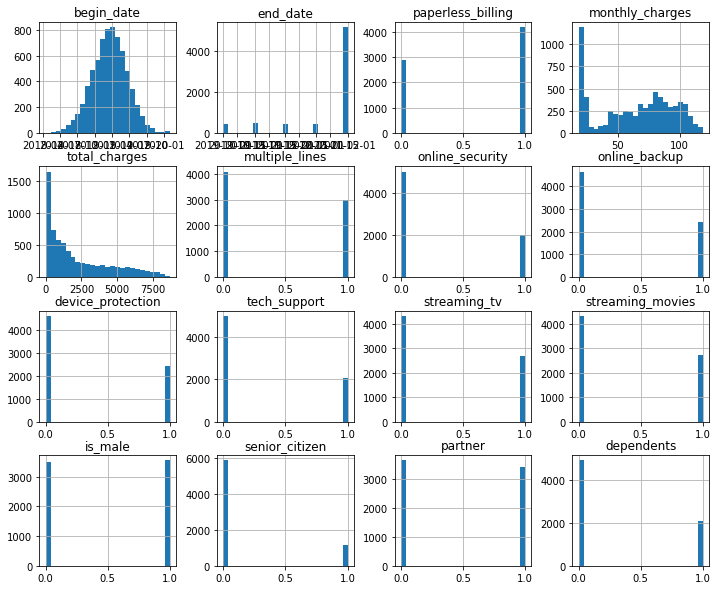

Размер датасета: (7043, 20)
Пропуски
customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
multiple_lines       0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
is_male              0
senior_citizen       0
partner              0
dependents           0
dtype: int64


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,is_male,senior_citizen,partner,dependents
2832,4389-UEFCZ,2019-09-30,2020-02-01,Two year,1,Electronic check,105.50,7544.00,1,Fiber optic,1,0,1,0,1,1,0,0,1,0
1923,8012-SOUDQ,2019-03-29,2020-02-01,Month-to-month,1,Electronic check,90.25,3838.75,1,Fiber optic,0,1,0,0,1,0,0,1,0,0
5617,4879-GZLFH,2019-03-24,2020-02-01,Month-to-month,1,Electronic check,92.15,3875.40,0,Fiber optic,0,0,1,0,1,1,0,0,1,1
2066,1984-GPTEH,2019-05-19,2020-02-01,Month-to-month,0,Electronic check,25.15,702.00,1,None,0,0,0,0,0,0,0,0,0,0
4362,1370-GGAWX,2019-04-02,2020-02-01,One year,1,Electronic check,94.15,4408.45,1,Fiber optic,0,1,1,0,0,1,0,0,0,0
1793,8676-TRMJS,2019-01-14,2020-01-01,Month-to-month,0,Mailed check,75.00,209.10,1,Fiber optic,0,0,0,0,0,0,1,0,0,0
4243,5879-HMFFH,2019-07-22,2020-02-01,Two year,0,Bank transfer (automatic),88.05,6520.80,1,DSL,1,1,1,1,1,1,0,0,1,0
3092,5980-BDHPY,2019-07-18,2020-02-01,Two year,1,Bank transfer (automatic),87.10,6230.10,1,DSL,1,1,1,1,1,1,1,0,1,0
2563,0835-JKADZ,2019-03-28,2020-02-01,Two year,1,Electronic check,111.25,7984.15,1,Fiber optic,0,1,1,1,1,1,0,0,0,0
673,0952-KMEEH,2019-01-21,2019-10-01,Month-to-month,0,Mailed check,98.15,1230.25,1,Fiber optic,1,0,0,0,1,1,1,0,0,0


In [51]:
first_look(data)

Сформируем целевую переменную.

In [52]:
data['is_break'] = data['end_date'].apply(lambda x: 1 if x != data['end_date'].max() else 0)

In [53]:
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,is_male,senior_citizen,partner,dependents,is_break
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,0.00,0,DSL,1,0,1,1,1,0,0,0,1,1,0
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,0.00,0,None,0,0,0,0,0,0,1,0,0,1,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,0,DSL,1,1,0,0,0,0,1,0,0,0,1
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,0,Mailed check,80.85,0.00,0,DSL,1,1,1,0,1,1,0,0,1,1,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,0,Fiber optic,0,0,0,0,0,0,0,0,0,0,1


Таким образом, задача сводится к задаче классификации активности абонента.

Далее посмотрим зависимости целевой переменной от признаков.

In [54]:
data.is_break.value_counts()

0    5174
1    1869
Name: is_break, dtype: int64

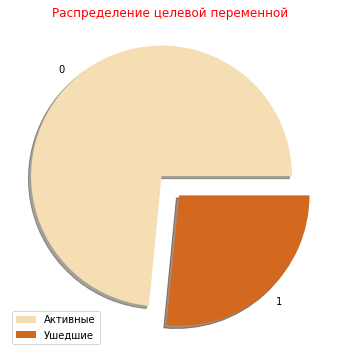

In [55]:
plt.pie(data['is_break'].value_counts(), labels=[0, 1], colors=['wheat', 'chocolate'], explode=[0.1, 0.1], shadow=True)
plt.title('Распределение целевой переменной', color='r')
plt.legend(['Активные', 'Ушедшие']);


Обратим внимание на дисбаланс в целевой переменной. Ушедших абонентов примерно втрое меньше оставшихся.

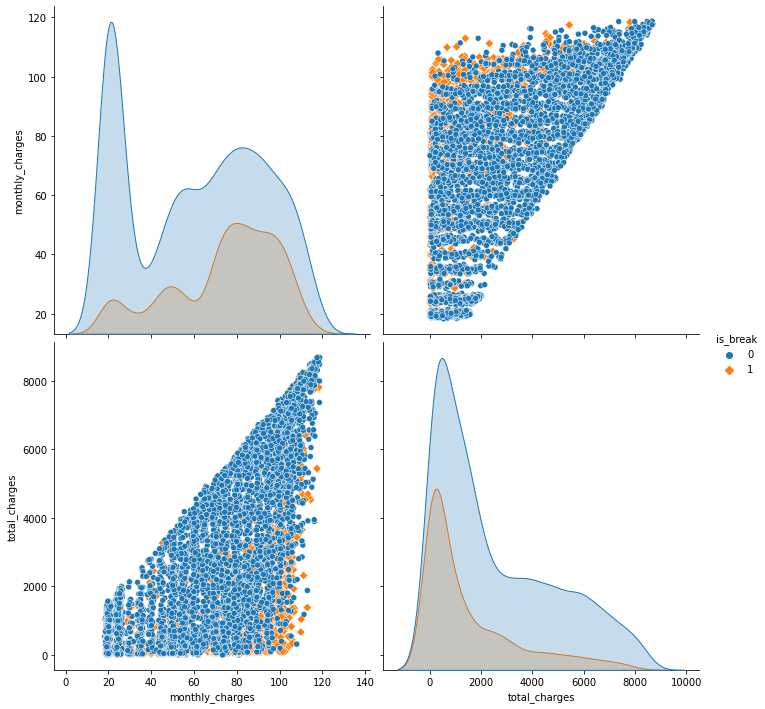

In [56]:
sns.pairplot(data, vars=['monthly_charges', 'total_charges'], hue='is_break', height=5, markers=["o",  "D"]);

Из графиков видим, что активные клиенты платят больше и в месяц, и всего.  

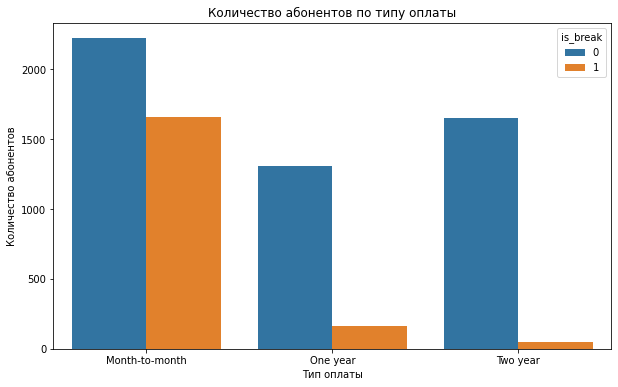

In [57]:
t = pd.DataFrame(data.groupby(['type', 'is_break'])['total_charges'].agg('count')).reset_index()


sns.barplot(x=t['type'], y=t['total_charges'], hue=t['is_break'].astype('category'))

plt.title('Количество абонентов по типу оплаты')
plt.xlabel('Тип оплаты')
plt.ylabel('Количество абонентов')
plt.show()

Чаще уходят абоненты с помесячным планом оплаты. Более долгие планы, вероятно, "держат" абонентов — зачем уходить, если услуга оплачена.

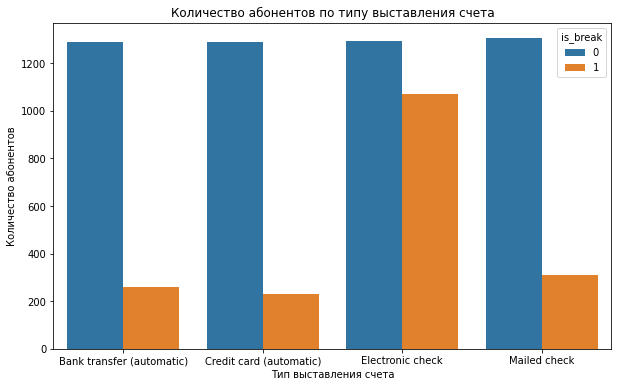

In [58]:
t = pd.DataFrame(data.groupby(['payment_method', 'is_break'])['total_charges'].agg('count')).reset_index()


sns.barplot(x=t['payment_method'], y=t['total_charges'], hue=t['is_break'].astype('category'))

plt.title('Количество абонентов по типу выставления счета')
plt.xlabel('Тип выставления счета')
plt.ylabel('Количество абонентов')
plt.show()

Реже уходят абоненты с получением счета по почте и "автоматические" абоненты. Видимо, первые — консерваторы-пенсионеры, которым сложно что-то менять в жизни, а вторые наоборот — молодые и шустрые :)

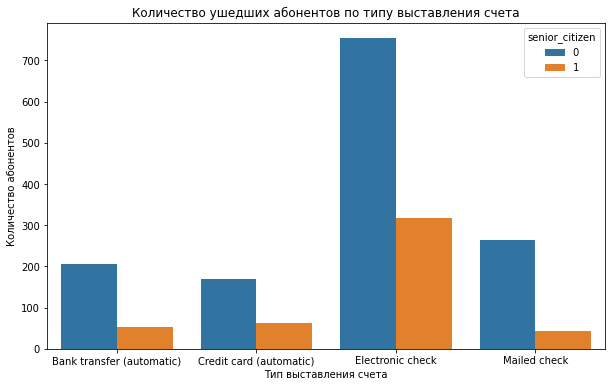

In [59]:
t = pd.DataFrame(data.query('is_break == 1').groupby(['payment_method', 'senior_citizen'])['total_charges'].agg('count')).reset_index()


sns.barplot(x=t['payment_method'], y=t['total_charges'], hue=t['senior_citizen'].astype('category'))

plt.title('Количество ушедших абонентов по типу выставления счета')
plt.xlabel('Тип выставления счета')
plt.ylabel('Количество абонентов')
plt.show()

Похоже на правду

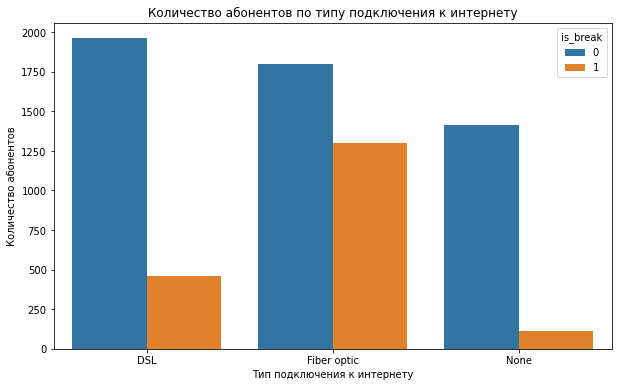

In [60]:
t = pd.DataFrame(data.groupby(['internet_service', 'is_break'])['total_charges'].agg('count')).reset_index()


sns.barplot(x=t['internet_service'], y=t['total_charges'], hue=t['is_break'].astype('category'))

plt.title('Количество абонентов по типу подключения к интернету')
plt.xlabel('Тип подключения к интернету')
plt.ylabel('Количество абонентов')
plt.show()

Интересно, что "телефонные" (без купленного подключения к интернету) абоненты уходя заметно реже!

А вот пользователи оптоволоконной линии - самые частые "бегуны". Скорость интернета намного ниже обещанной? :)

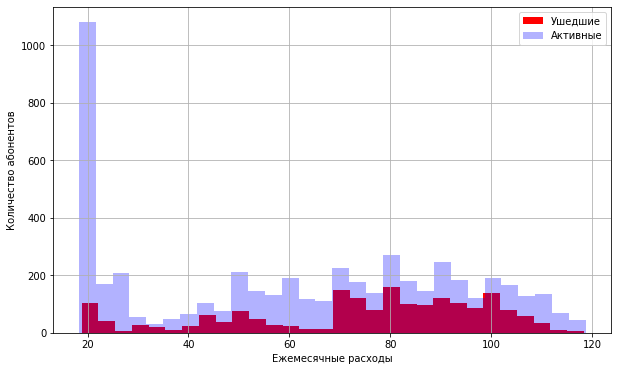

In [61]:
data.query('is_break == 1')['monthly_charges'].hist(bins=30, color='r')
data.query('is_break == 0')['monthly_charges'].hist(bins=30, color='b', alpha=.3)

plt.xlabel('Ежемесячные расходы')
plt.ylabel('Количество абонентов')
plt.legend(['Ушедшие', 'Активные']);

Судя по всему, пики на графике — оплата по определенным тарифам около круглых сумм (20, 50, 70, 80...)

### Краткий вывод

Данные объединены в общую таблицу, заполнены образовавшиеся в результате объединения пропуски.

Выделена целевая переменная исходя из наличия активного договора на максимальную дату наблюдений.  
В целевой переменной обнаружили дисбаланс классов.  

Значения признаков приведены к соответствующим типам.

Обнаружили несколько любопытных фактов:
* пользователи телефона уходят заметно реже;
* долгие планы лучше удерживают абонентов;
* оптоволоконная линия, вероятно, не устраивает пользователей интернета.

## Подготовка дополнительных признаков

Во-первых, посчитаем длительность активности абонента.

In [62]:
def get_duration(x):
    if x['type'] == 'Two year':
        return 24
    elif x['type'] == 'One year':
        return 12
    else:
        return np.ceil((x['end_date'] - x['begin_date'])/np.timedelta64(1, 'D'))

data['duration'] = data.apply(get_duration, axis=1)

In [63]:
data.duration.value_counts().sort_index()

12.0     1473
24.0     1695
26.0        1
39.0        1
42.0        2
         ... 
552.0       1
554.0       1
561.0       1
567.0       1
583.0       1
Name: duration, Length: 438, dtype: int64

И посмотрим на зависимость длительности контракта от ухода.

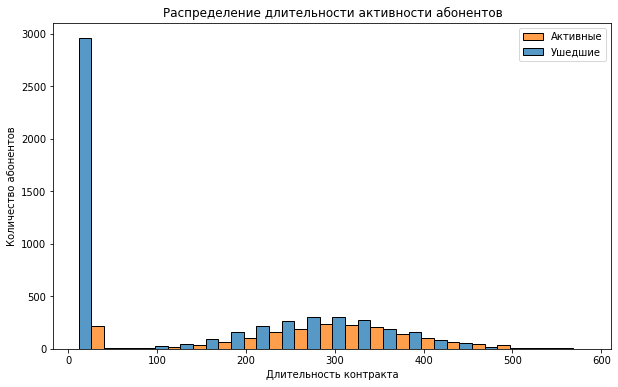

In [64]:
sns.histplot(data=data, x='duration', hue='is_break', multiple='dodge')

plt.xlabel('Длительность контракта')
plt.ylabel('Количество абонентов')
plt.legend(['Активные', 'Ушедшие'])
plt.title('Распределение длительности активности абонентов');

"Критический" период — 9—12 месяцев.  
Абонентам, пережившим год, можно выдавать почетное звание "старичка" :)

Во-вторых, добавим признаки "пользователь интернета" и "пользователь телефона".

In [65]:
data['is_internet_user'] = data['internet_service'].apply(lambda x: 1 if x != 'None' else 0)
data['is_phone_user'] = data['customer_id'].apply(lambda x: 1 if x in phone['customer_id'].values else 0)

В-третьих, посчитаем количество подписок на дополнительные сервисы.
Каждую телефонную линию (столбец `multiple_lines`) будем считать как отдельную услугу.

In [66]:
data['service_count'] = data['multiple_lines'] + data['online_security'] + data['online_backup'] + data['device_protection'] + data['tech_support'] + data['streaming_tv'] + data['streaming_movies']

В-четвертых, рассчитаем средние ежедневные затраты.

In [67]:
data['day_charges_mean'] = data['total_charges'] / data['duration']
data

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,is_male,senior_citizen,partner,dependents,is_break,duration,is_internet_user,is_phone_user,service_count,day_charges_mean
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,0.00,0,DSL,1,0,1,1,1,0,0,0,1,1,0,24.0,1,0,4,0.000000
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,0.00,0,None,0,0,0,0,0,0,1,0,0,1,0,24.0,0,1,0,0.000000
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,0,DSL,1,1,0,0,0,0,1,0,0,0,1,479.0,1,1,2,0.225783
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,0,Mailed check,80.85,0.00,0,DSL,1,1,1,0,1,1,0,0,1,1,0,24.0,1,1,5,0.000000
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,0,Fiber optic,0,0,0,0,0,0,0,0,0,0,1,279.0,1,1,0,0.543548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,2020-02-01,Two year,1,Bank transfer (automatic),21.15,1419.40,0,None,0,0,0,0,0,0,0,0,0,0,0,24.0,0,1,0,59.141667
7039,6840-RESVB,2019-02-26,2020-02-01,One year,1,Mailed check,84.80,1990.50,1,DSL,1,0,1,1,1,1,1,0,1,1,0,12.0,1,1,6,165.875000
7040,2234-XADUH,2019-09-02,2020-02-01,One year,1,Credit card (automatic),103.20,7362.90,1,Fiber optic,0,1,1,0,1,1,0,0,1,1,0,12.0,1,1,5,613.575000
7041,4801-JZAZL,2019-06-26,2020-02-01,Month-to-month,1,Electronic check,29.60,346.45,0,DSL,1,0,0,0,0,0,0,0,1,1,0,220.0,1,0,1,1.574773


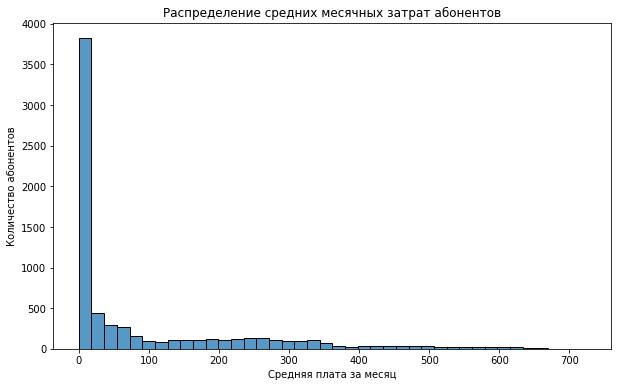

In [68]:
sns.histplot(data=data, x='day_charges_mean', bins=40)

plt.xlabel('Средняя плата за месяц')
plt.ylabel('Количество абонентов')
plt.title('Распределение средних месячных затрат абонентов');

Интересненько, есть абоненты с затратами выше 400/день. Приглядимся

In [69]:
data.query('day_charges_mean > 400')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,is_male,senior_citizen,partner,dependents,is_break,duration,is_internet_user,is_phone_user,service_count,day_charges_mean
49,0691-JVSYA,2018-09-17,2019-10-01,One year,1,Bank transfer (automatic),94.85,5000.20,0,Fiber optic,0,0,1,0,1,1,0,0,1,0,1,12.0,1,1,3,416.683333
94,4322-RCYMT,2018-12-06,2019-11-01,One year,1,Bank transfer (automatic),75.80,5293.95,1,DSL,0,1,1,1,0,1,1,0,1,1,1,12.0,1,1,5,441.162500
150,4710-FDUIZ,2019-01-04,2019-10-01,One year,0,Credit card (automatic),100.30,5614.45,1,Fiber optic,0,1,0,0,1,1,1,0,1,0,1,12.0,1,1,4,467.870833
164,4913-EHYUI,2019-10-19,2020-01-01,One year,1,Bank transfer (automatic),104.55,5794.65,1,Fiber optic,1,0,1,0,1,1,1,1,1,1,1,12.0,1,1,5,482.887500
204,0691-IFBQW,2019-02-20,2019-12-01,One year,1,Electronic check,110.00,4874.80,1,Fiber optic,1,1,1,0,1,1,0,1,0,0,1,12.0,1,1,6,406.233333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6991,9972-VAFJJ,2019-05-14,2020-02-01,One year,1,Electronic check,94.00,4871.45,0,Fiber optic,0,1,1,1,1,0,0,1,1,0,0,12.0,1,1,4,405.954167
6992,0422-UXFAP,2019-07-27,2020-02-01,One year,1,Electronic check,98.85,4947.55,1,Fiber optic,0,0,1,0,1,1,0,0,1,0,0,12.0,1,1,4,412.295833
7007,0218-QNVAS,2019-08-11,2020-02-01,One year,0,Bank transfer (automatic),100.55,7113.75,1,Fiber optic,0,1,0,0,1,1,1,0,1,1,0,12.0,1,1,4,592.812500
7026,7203-OYKCT,2019-10-27,2020-02-01,One year,1,Electronic check,104.95,7544.30,1,Fiber optic,0,1,1,0,1,1,1,0,0,0,0,12.0,1,1,5,628.691667


In [70]:
data.query('day_charges_mean > 400')['type'].value_counts()

One year          377
Month-to-month      0
Two year            0
Name: type, dtype: int64

Высокие затраты — у недавно подключенных абонентов с годовым планом.  
Посмотрим средний ежемесячный расход похожих абонентов.

In [71]:
data.query("type == 'One year' & service_count >= 4")['day_charges_mean'].mean()

387.98119083208775

In [72]:
data.groupby('internet_service')['day_charges_mean'].mean()

internet_service
DSL             97.016919
Fiber optic    119.863206
None            31.328200
Name: day_charges_mean, dtype: float64

Больший ежедневный расход у абонентов на оптоволокне.  
Тариф по трафику?  
Практически у всех подключены стриминги.

Ну и одна пенсионерка, отдавший за 2 месяца 3800 при абонентской плате в 70...  
Бабушку обманули корыстные менеджеры или пришлось тянуть оптоволокно за тридевять земель?

In [73]:
data.query('day_charges_mean < (monthly_charges / 30)')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,is_male,senior_citizen,partner,dependents,is_break,duration,is_internet_user,is_phone_user,service_count,day_charges_mean
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,0.00,0,DSL,1,0,1,1,1,0,0,0,1,1,0,24.0,1,0,4,0.000000
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,0.00,0,None,0,0,0,0,0,0,1,0,0,1,0,24.0,0,1,0,0.000000
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,0,DSL,1,1,0,0,0,0,1,0,0,0,1,479.0,1,1,2,0.225783
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,0,Mailed check,80.85,0.00,0,DSL,1,1,1,0,1,1,0,0,1,1,0,24.0,1,1,5,0.000000
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,0,Fiber optic,0,0,0,0,0,0,0,0,0,0,1,279.0,1,1,0,0.543548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6997,5351-QESIO,2019-01-18,2020-02-01,Month-to-month,0,Mailed check,24.20,24.20,0,DSL,0,0,0,0,0,0,1,0,0,1,0,379.0,1,0,0,0.063852
6998,5568-DMXZS,2019-02-16,2020-02-01,Month-to-month,1,Electronic check,65.45,554.45,0,DSL,0,1,0,1,1,0,0,0,0,0,0,350.0,1,1,3,1.584143
7022,1471-GIQKQ,2018-11-30,2020-02-01,Month-to-month,0,Electronic check,49.95,49.95,0,DSL,0,1,0,0,0,0,0,0,0,0,0,428.0,1,1,1,0.116706
7032,2235-DWLJU,2019-02-17,2020-02-01,Month-to-month,1,Electronic check,44.40,263.05,0,DSL,0,0,0,0,1,1,0,1,0,0,0,349.0,1,0,2,0.753725


И 1756 клиентов, платящих меньше тарифа. Скидки от провайдера?

---

Думаю, задачу упростило бы наличие информации по тарифам и детализации по абонентам.

Далее посмотрим на корреляцию признаков.

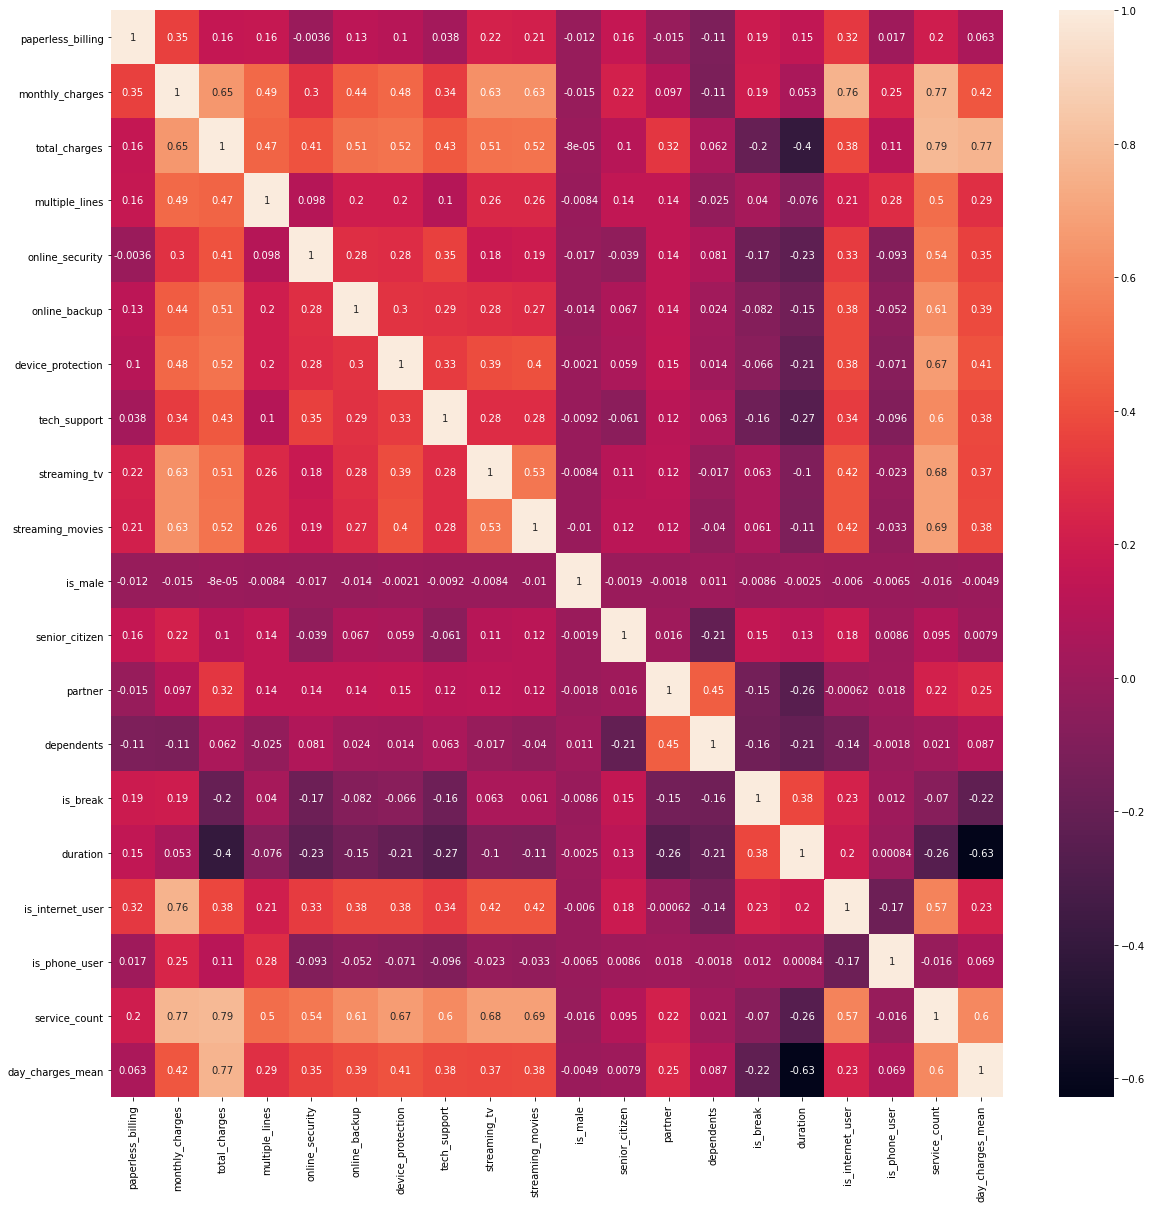

In [74]:
plt.figure(figsize=(20, 20))

sns.heatmap(data.corr(), annot=True);

Сильно коррелируют средние ежедневные затраты и общая сумма затрат (что неудивительно).  
Также заметна связь между количеством сервисов и самими сервисами.  

In [75]:
phik_corr = data.drop(['customer_id'], axis=1).phik_matrix()#, 'begin_date', 'end_date', 'paperless_billing'

phik_corr

interval columns not set, guessing: ['paperless_billing', 'monthly_charges', 'total_charges', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'is_male', 'senior_citizen', 'partner', 'dependents', 'is_break', 'duration', 'is_internet_user', 'is_phone_user', 'service_count', 'day_charges_mean']


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,is_male,senior_citizen,partner,dependents,is_break,duration,is_internet_user,is_phone_user,service_count,day_charges_mean
begin_date,1.000000,0.522116,0.129357,0.035787,0.098918,0.187101,0.000000,0.062805,0.133047,0.109448,0.000000,0.078877,0.000000,0.057824,0.033073,0.091464,0.139137,0.142517,0.077740,0.487635,0.899699,0.000000,0.000000,0.000000,0.000000
end_date,0.522116,1.000000,0.357462,0.156832,0.212169,0.319128,0.248533,0.034949,0.288479,0.139392,0.068364,0.051336,0.134227,0.050373,0.047014,0.000000,0.123124,0.121753,0.133425,1.000000,0.452035,0.185549,0.007161,0.148069,0.315040
type,0.129357,0.357462,1.000000,0.106860,0.277462,0.388266,0.505826,0.065498,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.000000,0.086231,0.179736,0.147680,0.251639,0.809293,0.146647,0.000000,0.456149,0.743536
paperless_billing,0.035787,0.156832,0.106860,1.000000,0.370495,0.467783,0.207127,0.252972,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.000000,0.242133,0.013218,0.172593,0.295754,0.221480,0.482393,0.016811,0.342467,0.170926
payment_method,0.098918,0.212169,0.277462,0.370495,1.000000,0.399536,0.350566,0.339313,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.000000,0.292725,0.243008,0.224903,0.449125,0.336599,0.535120,0.000000,0.463011,0.312576
monthly_charges,0.187101,0.319128,0.388266,0.467783,0.399536,1.000000,0.762907,0.676233,0.918980,0.551631,0.629573,0.667685,0.576217,0.835225,0.833391,0.009025,0.304691,0.203237,0.184213,0.360038,0.328974,0.998690,0.831362,0.781431,0.652646
total_charges,0.000000,0.248533,0.505826,0.207127,0.350566,0.762907,1.000000,0.606117,0.508222,0.545067,0.653989,0.671714,0.566062,0.660753,0.666609,0.000000,0.149384,0.424467,0.119077,0.278498,0.447335,0.556129,0.198660,0.659501,0.922852
multiple_lines,0.062805,0.034949,0.065498,0.252972,0.339313,0.676233,0.606117,1.000000,0.225383,0.151886,0.311403,0.309757,0.155739,0.392239,0.394553,0.000000,0.221313,0.220101,0.033103,0.059581,0.110691,0.323758,0.424315,0.721133,0.395928
internet_service,0.133047,0.288479,0.505187,0.231438,0.323886,0.918980,0.508222,0.225383,1.000000,0.241421,0.233602,0.232916,0.239663,0.272818,0.272782,0.000000,0.160702,0.000000,0.108463,0.196202,0.303049,1.000000,0.278954,0.634022,0.500720
online_security,0.109448,0.139392,0.152145,0.000000,0.262911,0.551631,0.545067,0.151886,0.241421,1.000000,0.430425,0.418474,0.528391,0.272186,0.289097,0.018397,0.057028,0.221673,0.124945,0.264580,0.320223,0.499319,0.143385,0.715051,0.559940


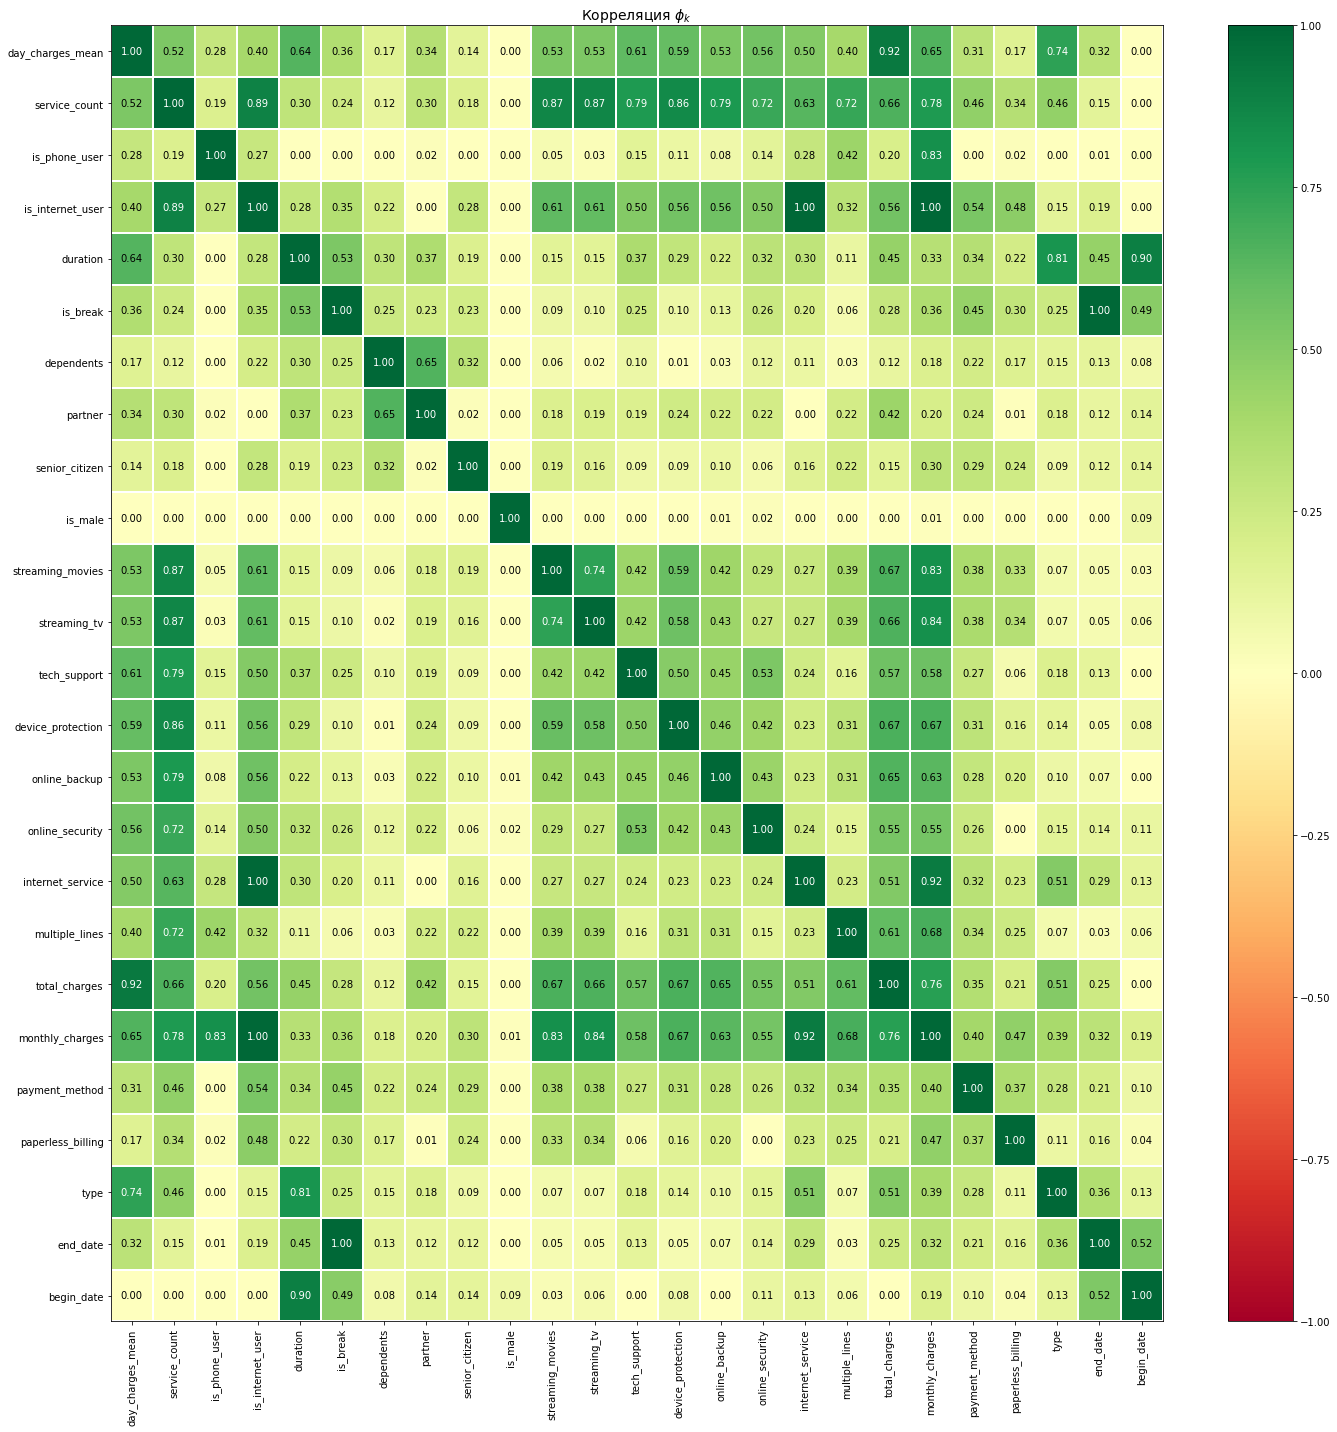

In [76]:

plot_correlation_matrix(
    phik_corr.values,
    x_labels=phik_corr.columns,
    y_labels=phik_corr.index,
    title='Корреляция $\phi_k$',
    identity_layout=True,
    figsize=(20, 20)
);

### Краткий вывод

Сформированы дополнительные признаки для данных:
* длительность контракта (фактическая для помесячных планов и 12/24 для одно- и двухлетних контрактов);
* пользование интернетом и телефоном;
* количество подключенных дополнительных сервисов;
* средние затраты в месяц.



## Подготовка данных для моделей машинного обучения

Нам не потребуются столбцы:
* `customer_id` — не несет полезной информации для моделей;
* `begin_date`, `end_date` — достаточно вычисленной длительности контракта;
* `paperless_billing` — фактически дублируется столбцом `payment_method`;
* `is_internet_user` — также дублер типа подключения (`internet_service`).


In [77]:
# Забакапим для возможных экспериментов
backup = data.copy()

data.drop(['customer_id', 'begin_date', 'end_date', 'paperless_billing', 'is_internet_user'], axis=1, inplace=True)



In [78]:
category_columns = ['type', 'payment_method', 'internet_service']

binary_columns = ['online_security', 'online_backup', 'device_protection', 
               'tech_support', 'streaming_tv', 'streaming_movies', 
               'is_male', 'senior_citizen', 'partner', 'dependents',
               'is_phone_user']

numeric_columns = ['monthly_charges', 'total_charges', 'multiple_lines', 
                   'duration', 'service_count', 'day_charges_mean']

data[category_columns + binary_columns] = data[category_columns + binary_columns].astype('category')

In [79]:
X = data.drop('is_break', axis=1)
y = data['is_break']

In [80]:
X_train, X_valid, y_train, y_valid = train_test_split(
                X, 
                y, 
                train_size=.75, 
                shuffle=True,
                stratify=y, 
                random_state=RS
            )


print('Размеры выборок:')
print(f'Обучающая выборка: {X_train.shape[0]} строк')
print(f'Валидационная выборка: {X_valid.shape[0]} строк')
print(f"Соотношение: ",
    f"{round(X_train.shape[0] / (X_train.shape[0] + X_valid.shape[0]) * 100, 2)} :",
    f"{round(X_valid.shape[0] / (X_train.shape[0] + X_valid.shape[0]) * 100, 2)}")

Размеры выборок:
Обучающая выборка: 5282 строк
Валидационная выборка: 1761 строк
Соотношение:  75.0 : 25.0


In [81]:
pipeline = make_column_transformer(
    (
        OneHotEncoder(
            drop='first', 
            handle_unknown='error'
            ), make_column_selector(dtype_include='category')
    ),
    (
        StandardScaler(
            ), make_column_selector(dtype_include='number')
    ), remainder='passthrough'

)

In [82]:
X_train_transformed = pipeline.fit_transform(X_train)

X_valid_transformed = pipeline.transform(X_valid)

### Краткий вывод

Выбраны необходимые признаки для обучения моделей.

Датасет разбит на обучающую и валидационную выборки в соотношении 0,75.  
Категориальные данные закодированы one-hot-кодированием, проведено масштабирование данных.

Теперь данные готовы для машинного обучения.

## Обучение моделей

В качестве моделей будем использовать RandomForest, CatBoost и нейронную сеть.

#### RandomForest

In [83]:
rf_model = RandomForestClassifier(random_state=RS)#, class_weight='balanced'

rf_model.fit(X_train_transformed, y_train)

rf_cv = (cross_val_score(rf_model, X_train_transformed, y_train, cv=3, scoring='roc_auc')).mean()

print('Предварительная оценка по ROC-AUC:', round(rf_cv, 4))

Предварительная оценка по ROC-AUC: 0.8211


Подберем гиперпараметры с помощью Optuna.

In [84]:
# Общие параметры
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=RS)

In [85]:
def objective_rf(trial):
    rf_params = {
        'n_estimators':trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_depth':trial.suggest_int('max_depth', 3, 10),
        'criterion':trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }
    
    model = RandomForestClassifier(**rf_params, 
                                   random_state=RS, 
                                   #class_weight='balanced'
                                   )
    
    model.fit(X_train_transformed, y_train)

    rf_cv = (cross_val_score(model, X_train_transformed, y_train, cv=5, scoring='roc_auc')).mean()
    
    return rf_cv


In [86]:
study_rf = optuna.create_study(study_name="RandomForest", direction="maximize", sampler=sampler)
study_rf.optimize(objective_rf, show_progress_bar=True, n_trials=100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [87]:
print('Number of finished trials: ', len(study_rf.trials))
print('Best trial:')
trial = study_rf.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

best_rocauc_rf = trial.value
best_model_rf = RandomForestClassifier(**trial.params, 
                                       random_state=RS, 
                                       #class_weight='balanced', 
                                       n_jobs=-1,
                                       verbose=0
                                       )

best_model_rf.fit(X_train_transformed, y_train)

best_acc_rf = (cross_val_score(best_model_rf, X_train_transformed, y_train, cv=5, scoring='accuracy')).mean()

Number of finished trials:  100
Best trial:
  Value:  0.8398519679086368
  Params: 
    n_estimators: 200
    max_depth: 6
    criterion: entropy


In [88]:
print('-'*50)
print('RANDOM FOREST')
print('Лучший показатель  ROC-AUC ', round(best_rocauc_rf, 4))
print('Лучший показатель  Accuracy', round(best_acc_rf, 4))
print('-'*50)

--------------------------------------------------
RANDOM FOREST
Лучший показатель  ROC-AUC  0.8399
Лучший показатель  Accuracy 0.7938
--------------------------------------------------


Даже с подбором гиперпараметров случайный лес не дотягивает до необходимого значения ROC-AUC.

#### CatBoost

Посмотрим, насколько хорошо справится CatBoost.

Сначала "скормим" ему кодированный датафрейм, потом проверим, будут ли лучше его встроенные алгоритмы для кодирования/масштабирования.

In [89]:
cb_model = CatBoostClassifier(random_state=RS, verbose=False, auto_class_weights='Balanced')

cb_model.fit(X_train_transformed, y_train)

cb_cv = (cross_val_score(cb_model, X_train_transformed, y_train, cv=5, scoring='roc_auc')).mean()

print('Предварительная оценка по ROC-AUC:', round(cb_cv, 4))

Предварительная оценка по ROC-AUC: 0.8335


Подберем гиперпараметры с помощью Optuna.

In [90]:
def objective_CB_enc(trial):
    params = {
        "iterations" : trial.suggest_int('iterations', 500, 800),
        "learning_rate" : trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        "depth" : trial.suggest_int('depth', 4, 8),
        "l2_leaf_reg" : trial.suggest_float('l2_leaf_reg', 1e-5, 10.0, log=True),
        "random_strength" : trial.suggest_float('random_strength', 1e-6, 10.0, log=True),
        "bagging_temperature" : trial.suggest_float('bagging_temperature', 0.0, 10.0),
        "od_type" : trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "od_wait" : trial.suggest_int('od_wait', 20, 50)
    }
    
    model = CatBoostClassifier(**params,
                               auto_class_weights='Balanced',
                               random_state=RS, 
                               verbose=False,
                               #task_type='GPU',
                               #devices='0:1'
    )

    model.fit(X_train_transformed, y_train)
    
    scores = cross_val_score(model, X_train_transformed, y_train, cv=3, scoring='roc_auc')
    
    return scores.mean()


In [91]:
study_CB_enc = optuna.create_study(study_name="catboost_enc", direction="maximize", sampler=sampler)
study_CB_enc.optimize(objective_CB_enc, show_progress_bar=True, n_trials=100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [92]:
print('Number of finished trials: ', len(study_CB_enc.trials))
print('Best trial:')
trial = study_CB_enc.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')



Number of finished trials:  100
Best trial:
  Value:  0.840505453251188
  Params: 
    iterations: 637
    learning_rate: 0.005642860993057196
    depth: 5
    l2_leaf_reg: 6.490410352134476
    random_strength: 0.0004638735282261726
    bagging_temperature: 4.723589437358683
    od_type: Iter
    od_wait: 35


In [93]:
best_rocauc_CB_enc = trial.value

best_model_CB_enc = CatBoostClassifier(**trial.params,
                                       auto_class_weights='Balanced', 
                                       random_state=RS, 
                                       verbose=False, 
                                       #task_type='GPU',
                                       #devices='0:1'
                                      )

In [94]:
best_model_CB_enc.fit(X_train_transformed, y_train)

best_acc_cb_enc = (cross_val_score(best_model_CB_enc, X_train_transformed, y_train, cv=5, scoring='accuracy')).mean()

In [95]:
print('-'*50)
print('CATBOOST (encoded data)')
print('Лучший показатель  ROC-AUC ', round(best_rocauc_CB_enc, 4))
print('Лучший показатель  Accuracy', round(best_acc_cb_enc, 4))
print('-'*50)

--------------------------------------------------
CATBOOST (encoded data)
Лучший показатель  ROC-AUC  0.8405
Лучший показатель  Accuracy 0.7473
--------------------------------------------------


И некодированные данные.

In [96]:
def objective_CB_orig(trial):
    params = {
        "iterations" : trial.suggest_int('iterations', 500, 800),
        "learning_rate" : trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        "depth" : trial.suggest_int('depth', 4, 8),
        "l2_leaf_reg" : trial.suggest_float('l2_leaf_reg', 1e-5, 10.0, log=True),
        "random_strength" : trial.suggest_float('random_strength', 1e-6, 10.0, log=True),
        "bagging_temperature" : trial.suggest_float('bagging_temperature', 0.0, 10.0),
        "od_type" : trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "od_wait" : trial.suggest_int('od_wait', 20, 50)
    }
    
    model = CatBoostClassifier(**params,
                               auto_class_weights='Balanced',
                               random_state=RS, 
                               verbose=False,
                               cat_features=category_columns + binary_columns,
                               #task_type='GPU',
                               #devices='0:1'
    )

    model.fit(X_train, y_train)
    
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
        
    return scores.mean()

In [97]:
study_CB_orig = optuna.create_study(study_name="catboost_orig", direction="maximize", sampler=sampler)
study_CB_orig.optimize(objective_CB_orig, show_progress_bar=True, n_trials=100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [98]:
print('Number of finished trials: ', len(study_CB_orig.trials))
print('Best trial:')
trial = study_CB_orig.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')



Number of finished trials:  100
Best trial:
  Value:  0.8413042003023067
  Params: 
    iterations: 672
    learning_rate: 0.015668088028779625
    depth: 4
    l2_leaf_reg: 0.003796606977952005
    random_strength: 1.3874543078056543
    bagging_temperature: 0.025161538004785267
    od_type: Iter
    od_wait: 34


In [99]:
best_rocauc_CB_orig = trial.value

best_model_CB_orig = CatBoostClassifier(**trial.params,
                                       auto_class_weights='Balanced', 
                                       random_state=RS, 
                                       verbose=False,
                                       cat_features=category_columns + binary_columns, 
                                       #task_type='GPU',
                                       #devices='0:1'
                                       )

In [100]:
best_model_CB_orig.fit(X_train, y_train)

best_acc_cb_orig = (cross_val_score(best_model_CB_orig, X_train, y_train, cv=5, scoring='accuracy')).mean()

In [101]:
print('-'*50)
print('CATBOOST (original data)')
print('Лучший показатель  ROC-AUC ', round(best_rocauc_CB_orig, 4))
print('Лучший показатель  Accuracy', round(best_acc_cb_orig, 4))
print('-'*50)

--------------------------------------------------
CATBOOST (original data)
Лучший показатель  ROC-AUC  0.8413
Лучший показатель  Accuracy 0.7471
--------------------------------------------------


#### Neural Net

Создадим сеть из одного входного слоя (по размеру тренировочного датасета), одного скрытого и выходного слоя.


In [102]:
class SkyNet(nn.Module):
    def __init__(
        self, 
        n_in_neurons, 
        n_hidden_neurons_1, 
        n_hidden_neurons_2, 
        n_hidden_neurons_3,
        n_out_neurons):
            super(SkyNet, self).__init__()
            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.batch1 = nn.BatchNorm1d(n_hidden_neurons_1)
            self.act1 = nn.Sigmoid()
            
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            #self.batch2 = nn.BatchNorm1d(n_hidden_neurons_2)
            self.act2 = nn.Sigmoid()
            
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
            self.batch3 = nn.BatchNorm1d(n_hidden_neurons_3)
            self.act3 = nn.Tanh()

            self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)
            self.batch4 = nn.BatchNorm1d(n_out_neurons)
            self.act4 = nn.Sigmoid()

    def forward(self, x):
       x = self.fc1(x)
       x = self.batch1(x)
       x = self.act1(x)
       x = self.fc2(x)
       #x = self.batch2(x)
       x = self.act2(x)
       x = self.fc3(x)
       x = self.batch3(x)
       x = self.act3(x)
       x = self.fc4(x)
       x = self.batch4(x)
       x = self.act4(x)
       return x 

In [103]:
# Переведем датасеты в тензоры

X_train_tensor = torch.from_numpy(X_train_transformed).float().to(device)
X_valid_tensor = torch.from_numpy(X_valid_transformed).float().to(device)

y_train_tensor = torch.from_numpy(y_train.values).float().to(device)
y_valid_tensor = torch.from_numpy(y_valid.values).float().to(device)

loss = nn.BCEWithLogitsLoss()

In [104]:
X_train_tensor.unique()
#.shape[1], y_train_tensor.shape[1], X_valid_tensor.shape[1], y_valid_tensor.shape[1]

tensor([-1.5448, -1.5398, -1.5299,  ...,  4.0642,  4.1802,  4.3982])

In [105]:
# Функция обучения сети

def train_skynet(num_epochs):
    result = {}
    res_acc = []

    for epoch in range(num_epochs):
        net.train()
        optimizer.zero_grad()

        preds = net.forward(X_train_tensor).flatten()

        loss_value = loss(preds, y_train_tensor)

        loss_value.backward()

        optimizer.step()

        if epoch % 100 == 0 or epoch == num_epochs - 1:
            net.eval()
            test_preds = net.forward(X_valid_tensor).flatten()
            roc_auc = roc_auc_score(y_valid_tensor.to('cpu').detach().numpy(), test_preds.to('cpu').detach().numpy())
            #acc =  accuracy_score(y_valid_tensor.to('cpu').detach().numpy(), test_preds.to('cpu').detach().numpy())
            print('Epoch:', epoch)
            print('ROC-AUC:', roc_auc) #, '; accuracy:', acc)
            print('='*50)
            result[epoch] = roc_auc
            #res_acc.append(acc)
    return result, test_preds



In [106]:
n_in_neurons = X_train_transformed.shape[1]
n_hidden_neurons_1 = 1024
n_hidden_neurons_2 = 256
n_hidden_neurons_3 = 128
n_out_neurons = 1

In [107]:
net = SkyNet(n_in_neurons,
        n_hidden_neurons_1,
        n_hidden_neurons_2,
        n_hidden_neurons_3,
        n_out_neurons)

net.to(device)

SkyNet(
  (fc1): Linear(in_features=24, out_features=1024, bias=True)
  (batch1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): Sigmoid()
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (act2): Sigmoid()
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (batch3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): Tanh()
  (fc4): Linear(in_features=128, out_features=1, bias=True)
  (batch4): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act4): Sigmoid()
)

In [108]:
# def init_weights(layer):
#     if type(layer) == nn.Linear: 
#         nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu') 

# net.apply(init_weights)

In [109]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)
result, predictions = train_skynet(5001)

best_rocauc_nn = max(result.values())

print('\n','* '*50)
print(f'Epoch: {max(result, key=result.get)}, ROC-AUC: {max(result.values())}')

Epoch: 0
ROC-AUC: 0.24844282125706194
Epoch: 100
ROC-AUC: 0.839011547282963
Epoch: 200
ROC-AUC: 0.8373947952831219
Epoch: 300
ROC-AUC: 0.8329731357707622
Epoch: 400
ROC-AUC: 0.8226156631330899
Epoch: 500
ROC-AUC: 0.8031401725638675
Epoch: 600
ROC-AUC: 0.7854915952063387
Epoch: 700
ROC-AUC: 0.7793423112437904
Epoch: 800
ROC-AUC: 0.7713942458853084
Epoch: 900
ROC-AUC: 0.7663387931120076
Epoch: 1000
ROC-AUC: 0.7579207609490682
Epoch: 1100
ROC-AUC: 0.7516457112219468
Epoch: 1200
ROC-AUC: 0.7473911877914539
Epoch: 1300
ROC-AUC: 0.7441345164140871
Epoch: 1400
ROC-AUC: 0.7422463751327987
Epoch: 1500
ROC-AUC: 0.7355195615408292
Epoch: 1600
ROC-AUC: 0.7373828806317413
Epoch: 1700
ROC-AUC: 0.7320841703927532
Epoch: 1800
ROC-AUC: 0.729683037177022
Epoch: 1900
ROC-AUC: 0.7280083667329695
Epoch: 2000
ROC-AUC: 0.7246209651529544
Epoch: 2100
ROC-AUC: 0.7268384141599012
Epoch: 2200
ROC-AUC: 0.725388798241927
Epoch: 2300
ROC-AUC: 0.7218292961419697
Epoch: 2400
ROC-AUC: 0.718145683090131
Epoch: 2500
ROC

Сведем результаты в табличку

In [110]:
train_score = pd.DataFrame({
    'RandomForest' : [best_rocauc_rf, best_acc_rf],
    'CatBoost_enc': [best_rocauc_CB_enc, best_acc_cb_enc],
    'CatBoost_orig': [best_rocauc_CB_orig, best_acc_cb_orig],
    'Neural Net': [best_rocauc_nn, "—"],

}, index=['ROC-AUC', 'Accuracy'])

train_score

,RandomForest,CatBoost_enc,CatBoost_orig,Neural Net
ROC-AUC,0.839852,0.840505,0.841304,0.839012
Accuracy,0.793825,0.747256,0.747066,—


### Краткий вывод

Обучены модели случайного леса, CatBoost (с предварительным кодированием и без него) и нейронной сети.  
Моделям подобраны гиперпараметры с помощью Optuna.


Лучший показатель по метрике ROC-AUC (0,8413) показала модель CatBoost без кодирования признаков.  
Точность (accuracy) данной модели составила 0,74706.  

Для проверки на тестовых данных будем использовать ее.

## Проверка на тестовой выборке

In [111]:
dummy = DummyClassifier(strategy="stratified")

dummy.fit(X_train_transformed, y_train)

dummy_preds = dummy.predict(X_valid_transformed)

print('Dummy ROC-AUC on test', roc_auc_score(y_valid, dummy_preds))

Dummy ROC-AUC on test 0.5033832645482857


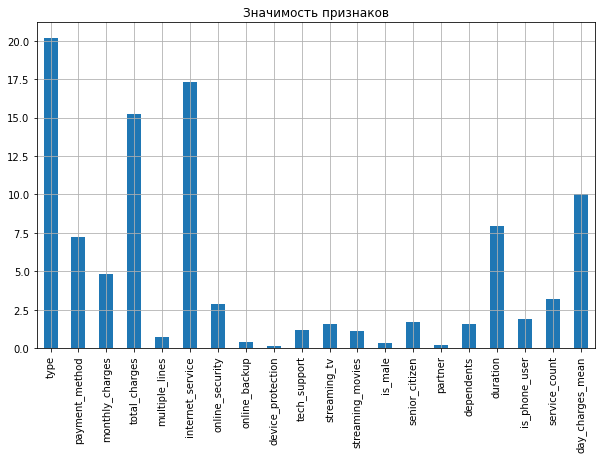

In [112]:
importances = best_model_CB_orig.get_feature_importance()
feature_names = X_train.columns


pd.Series(importances, index=feature_names).plot.bar()
plt.title('Значимость признаков')
plt.grid(True)
plt.show()

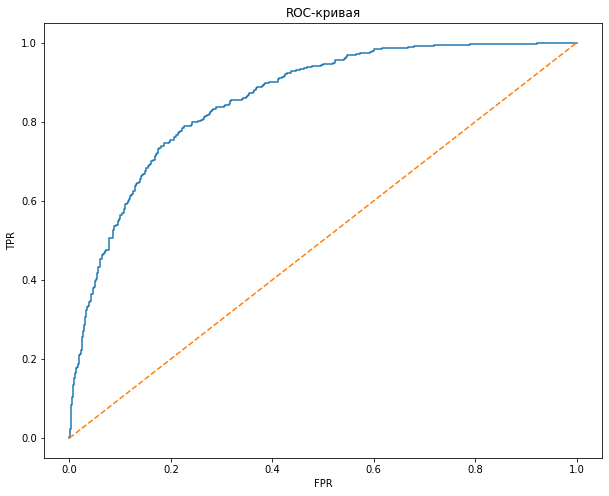

ROC-AUC-мера модели: 0.856871940665036
Test Accuracy: 0.7620670073821693


In [113]:
test_preds = best_model_CB_orig.predict(X_valid)

probalities_one_valid = best_model_CB_orig.predict_proba(X_valid)[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid, probalities_one_valid)

plt.figure(figsize=(10, 8))
plt.xlabel("FPR")
plt.ylabel("TPR")

plt.title('ROC-кривая')

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')


plt.show()

print('ROC-AUC-мера модели:', roc_auc_score(y_valid, probalities_one_valid))
print('Test Accuracy:', accuracy_score(y_valid, test_preds))

Подберем порог.

In [114]:
proba_one = best_model_CB_orig.predict_proba(X_valid)[:, 1]
best_treshold = 0
best_accuracy = 0

for treshold in np.arange(0, 1, 0.01):
    y_pred = proba_one > treshold
    accuracy = accuracy_score(y_valid, y_pred)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_treshold = treshold

print('Оптимальный порог:', best_treshold)
print(f'Точность при пороге {best_treshold}: {round(best_accuracy, 3)}')

Оптимальный порог: 0.73
Точность при пороге 0.73: 0.811


Построим матрицу ошибок.

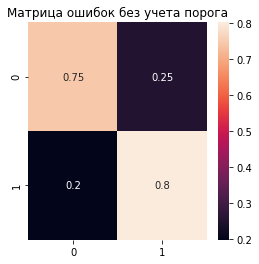

In [115]:
conf_matrix = confusion_matrix(y_valid, test_preds, normalize='true')

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True)

plt.title('Матрица ошибок без учета порога')
plt.show()

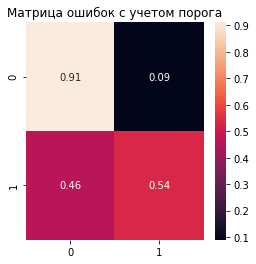

In [116]:
treshhold_predictions = proba_one > best_treshold
conf_matrix = confusion_matrix(y_valid, treshhold_predictions, normalize='true')
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True)

plt.title('Матрица ошибок с учетом порога')
plt.show()

При учете порога матрица ошибок выглядит куда как более интересно.

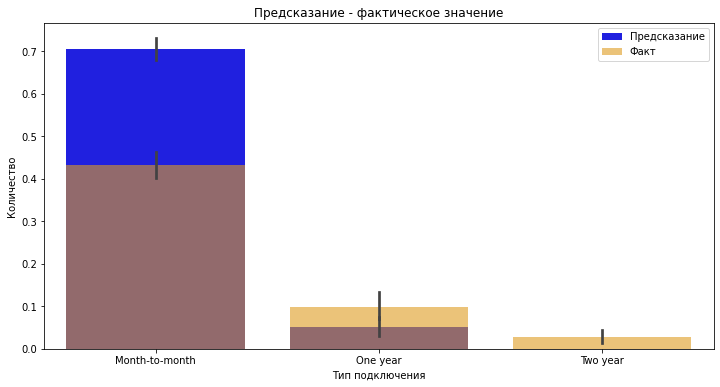

In [ ]:
visual_df = pd.DataFrame({'Type': X_valid['type'], 'Fact': y_valid, 'Prediction': test_preds})


plt.figure(figsize=(12, 6))

sns.barplot(data=visual_df, x=visual_df.Type, y='Prediction', color='blue', label='Предсказание')
sns.barplot(data=visual_df, x=visual_df.Type, y='Fact', color='orange', label='Факт', alpha=.6)
plt.title('Предсказание - фактическое значение')
plt.ylabel('Количество')
plt.xlabel('Тип подключения')
plt.legend()

plt.show()


Сильнее всего модель ошибается при классификации "помесячных" абонентов.

### Краткий вывод

Модель проверена на тестовой выборке.  
Проведен анализ входных признаков. Наиболее важными оказались:
* тип контракта;
* длительность контракта (сгенерированный признак);
* тип подключения к интернету;
* все признаки, связанные с деньгами.

## Выводы

Для решения задачи предсказания оттока абонентов проведены следующие действия.

Из БД выгружены доступные данные.  
Данные проверены на адекватность и полноту, объединены в единый датафрейм.  
Итого получилось 7043 записи. На основе исходных данных сгенерированы новые признаки:
* дительности контракта;
* количества подключенных дополнительных услуг;
* среднего расхода за месяц.

Обработаны пропуски, проведен исследовательский анализ.

Данные подготовлены для подачи моделям машинного обучения - проведено масшибаиролвание и кодирование данных.

Обучены модели случайного леса, CatBoost (с предварительным кодированием и без него) и нейронная сеть.  
Моделям подобраны гиперпараметры для наилучшего результата.

По итогам обучения лучше всех показала себя модель CatBoost без предварительной обработки.

Модель проверена на тестовых данных, сравнена с константной моделью.
Показатель по метрике ROC-AUC на тестовой выборке равен 0.85744, что достаточно для требований заказчика.  
Проведен анализ входных признаков. Наиболее важными оказались:
* тип контракта;
* длительность контракта (сгенерированный признак);
* тип подключения к интернету;
* все признаки, связанные с деньгами.


Рекомендации для улучшения качества предсказаний:
* добавить данные с детализацией по абонентам (расход трафика, частота использования допуслуг etc.);
* добавить информацию по тарифам (к примеру, цены на допуслуги, условия подключения etc.);
* предоставить данные за более широкий период.